In [1]:
import numpy as np
from qutip import *
from scipy import stats as st
import scipy as sc
from numpy import imag, real
import time
import scipy.sparse as sp
import matplotlib.pyplot as plt
import matplotlib as mpl

## some initialization for figures (not important)

In [2]:
font_size=20
letter_size=22
label_size=25
title_font=28
legend_size=23

from matplotlib import rc
rc('font', family='serif', size=font_size)
rc('text', usetex=True)



mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['axes.labelsize'] = label_size
mpl.rcParams['xtick.minor.visible']=True
mpl.rcParams['xtick.major.size']=6
mpl.rcParams['xtick.minor.size']=3
mpl.rcParams['xtick.major.width']=1.4
mpl.rcParams['xtick.minor.width']=0.9
mpl.rcParams['xtick.direction']='in'

mpl.rcParams['ytick.minor.visible']=True
mpl.rcParams['ytick.major.size']=6
mpl.rcParams['ytick.minor.size']=3
mpl.rcParams['ytick.major.width']=2.1
mpl.rcParams['ytick.minor.width']=1.3
mpl.rcParams['ytick.direction']='in'

mpl.rcParams['ytick.direction']='in'



mpl.rcParams['legend.fontsize']=legend_size



import matplotlib.ticker
class MyLocator(matplotlib.ticker.AutoMinorLocator):
    def __init__(self, n=2):
        super().__init__(n=n)
matplotlib.ticker.AutoMinorLocator = MyLocator        


marker_sz = 10
location='upper left'
properties={'size':12}
width_plot=8



def get_axis_limits(ax, scalex=.1, scaley=.85):
    return (ax.get_xlim()[0] + (ax.get_xlim()[1]-ax.get_xlim()[0])*scalex, ax.get_ylim()[0]+(ax.get_ylim()[1]-ax.get_ylim()[0])*scaley)

colorlist=[plt.cm.brg(i) for i in np.linspace(0, 1, 6)]

# The Arnoldi-Lindblad time evolution code

In [3]:
def arnoldi_time_evolution(H, c_ops, vec_init,n , T, numsteps=100, condition='steady_state', tau=10**(-3), min_check=100, how_often=20):
    """    Computes the orthonormal basis of the (n + 1)-Krylov subspace of 
    mat spanned by {vec, mat*vec, ..., mat^n*vec}.

    Arguments
      H: Hamiltonian of the system
      c_ops: dissipation operators of the systems
      vec_init:  initial density matrix 
      n: maximal dimension of the Krylov subspace, must be an integer
      T: evolution time per iteration
      numsteps: number of steps in the time evolution up to time T
      condition: condition for the wanted eigenvalues; function or keyword
      tau: precision
      min_check: iteration number where checking for convergency starts
      how_often: interval of number of iterations where it checks for convergence
    
    Returns
      Q: m x (n + 1) array of Qobj, the columns are an orthonormal basis of the
        Krylov subspace.
      h: (n + 1) x n array, E on basis S. It is upper Hessenberg and its 
          eigenvalues and eigenvectors converge towards those of E. 
      vals_good: converged eigenvalues of the evolution operator.
      vecs_eff_good: converged right eigenvectors of the evolution operator/
          Liouvillian.
      vals_liouv_good: converged eigenvalues of the Liouvillian.
      
    """
    
    HH=H.full()
    cc_ops=[cc.full() for cc in c_ops]
    def do_liouvillian(rho):
        Lrho= -1.j*(np.dot(HH,rho) - np.dot(rho,HH))
        for jump in cc_ops:
            Lrho=Lrho + np.dot(jump,np.dot(rho,np.conj(np.transpose(jump))))- 0.5*(np.dot(rho,np.dot(np.conj(np.transpose(jump)),jump))+ np.dot(np.dot(np.conj(np.transpose(jump)),jump),rho))
        return Lrho
    
    
    if condition=='steady_state':
        def condition(vv, vals):
            return np.abs(vv)>0.95
    elif isinstance(condition, int):
        NN=condition
        def condition(vv, vals):
            index=np.argsort(abs(vals))
            return vv in vals[index[-NN:]]
        

    q = operator_to_vector(vec_init).full()[:,0]
    q/=np.linalg.norm(q)
    m = q.shape[0]
    sqrtm = int(np.sqrt(m))
    h=np.zeros((n + 1, n), dtype=np.complex128)
    Q=np.zeros((m, n+1), dtype=np.complex128)
    Q[:, 0] = q  # Use it as the first Krylov vector

    tlist=np.linspace(0, T, numsteps)
    
    for k in range(n):
                     
        q=q.reshape((sqrtm,sqrtm))
        q=Qobj(q, dims=vec_init.dims, shape=vec_init.shape)
        sol=mesolve(H, q, tlist, c_ops) #When not using QUTIP, use your own time evolution function here.
                
        v = sol.states[-1]  # Generate a new candidate vector
        v=(v.full()).reshape((m,))
        for j in range(k + 1):  # Subtract the projections on previous vectors
            h[j, k] = np.dot(np.conj(Q[:, j]),v)
            v = v - h[j, k] * Q[:, j]

        h[k + 1, k] = np.linalg.norm(v)
        """
        Orthonormalization is sub-optimal but more numerically stable
        """
        eps = 1e-12  # If v is shorter than this threshold it is the zero vector
        if h[k + 1, k] > eps:  # Add the produced vector to the list, unless
            q = v / h[k + 1, k]  # the zero vector is produced.
            Q[:, k + 1] = q

         
        
        convergence=0
        
        """
        The following part is extremely sub-obptimal. How can we improve it?
        """
        
        if k%how_often==0 and k>min_check:

            vals_eff, vecs_eff=np.linalg.eig(h[0:k, 0:k]) #calculate the effective eigenvalues and eigenvectors

            vals_good=[]
            vals_liouv_good=[]
            vecs_eff_good=[]
            convergence=1
            for jj in range(len(vals_eff)): #loop to see which eigenvalues/ eigenvectors have converged
                if condition(vals_eff[jj], vals_eff)==True:
                    
                    vec=vecs_eff[:,jj]
                    vec=np.dot(Q[:,0:k],vec) #transforms the vector in the effective basis to one expressed in the original basis
                    vec=vec/np.linalg.norm(vec)
                    vec_r=vec.reshape((sqrtm,sqrtm))
                    
                    qq=Qobj(vec_r, dims=vec_init.dims, shape=vec_init.shape)

                    sol=mesolve(H, qq, tlist, c_ops) #When not using QUTIP, use your own time evolution function here.
                    
                    
                    diff=vals_eff[jj]*qq-sol.states[-1]
                    if diff.norm()<tau: #convergence measure
                        convergence*=1
                        vals_good.append(vals_eff[jj]) #appends converged eigenvalue of the evolution operator
                        qq=sol.states[-1].full() 
                        qq/=np.linalg.norm(qq) 
                        Lv=do_liouvillian(qq) 
                        vals_liouv_good.append(np.dot(np.conj(qq).reshape((m,)), Lv.reshape((m,))))   #calculates and appends the eigenvalue of the Liouvillian
                        vecs_eff_good.append(qq) #appends the converged eigenvector
                    else:
                        convergence*=0
                    
            
        if convergence: break
            
        if h[k + 1, k] < eps:  # If that happens, stop iterating.
            break
    print('Total number of iterations = '+str(k))
    return Q, h, vals_good, vecs_eff_good, vals_liouv_good


# DIMER example

## Define the system

In [4]:
gamma=1
F=4.5
U=20
J=10
Delta=5

In [5]:
cutoff=8
a=tensor(destroy(cutoff), qeye(cutoff))
b=tensor(qeye(cutoff), destroy(cutoff))
H=-Delta*(a.dag()*a+b.dag()*b) + F*(a+a.dag()+b+b.dag()) +U/2*(a.dag()**2*a**2+b.dag()**2*b**2) 
H=H- J * (a.dag()*b +b.dag()*a)
c_ops=[np.sqrt(gamma)*a, np.sqrt(gamma)*b]
LL=liouvillian(H, c_ops)
T=0.05


## Random initial state

In [6]:
vec_init=np.random.random(a.shape[0])
vec_init=vec_init/np.sum(vec_init)
R=st.special_ortho_group.rvs(len(vec_init))
vec_init=Qobj(np.dot(np.dot(R, np.diag(vec_init)), R.T),dims=a.dims, shape=a.shape)
vec_init=vec_init/vec_init.tr()

## Do the Arnoldi-Lindblad time evolution for the steady state

In [7]:
tic=time.time()

Q_ss, h_ss, vals_good_ss, vecs_eff_ss,vals_liouv_ss=arnoldi_time_evolution(H, c_ops, vec_init, 301, T, numsteps=10, condition=int(1), tau=10**(-3), min_check=80, how_often=10)

toc=time.time()


Total number of iterations = 120


In [8]:
print(vals_liouv_ss)

[(-9.082570872463524e-05-1.6450189599176088e-14j)]


## Do the Arnoldi-Lindblad time evolution for 5 converged eigenvalues

In [9]:
tic=time.time()

Q_5, h_5, vals_good_5, vecs_eff_good_5,vals_liouv_good_5=arnoldi_time_evolution(H, c_ops, vec_init, 171, T, numsteps=10, condition=int(5), tau=10**(-3))

toc=time.time()



Total number of iterations = 160


In [10]:
print(vals_liouv_good_5)

[(1.6029119718759333e-07+1.3958622623660438e-14j), (-0.13479678225917335+3.0046494806090784e-15j), (-1.0352247734068216-8.356032879519582e-14j), (-0.9884839041650793-35.29659131138924j), (-0.9884839041650801+35.29659131138931j)]


## Do the Arnoldi-Lindblad time evolution for 10 converged eigenvalues

In [11]:
tic=time.time()

Q_10, h_10, vals_good_10, vecs_eff_good_10,vals_liouv_good_10=arnoldi_time_evolution(H, c_ops, vec_init, 241, T, numsteps=10, condition=int(10), tau=10**(-3))

toc=time.time()

Total number of iterations = 200


In [12]:
print(len(vals_liouv_good_10))

10


In [13]:
print(toc-tic)

28.44074845314026


## The exact solution

In [14]:
tic=time.time()
LLval, LLvecs=LL.eigenstates()
toc=time.time()

In [15]:
print(toc-tic)

146.68253469467163


## A figure of the results

In [16]:
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import numpy as np

my_c=[ 1,  2,  2,  2, 79]
my_v=[[0.0, -0.5],   [0.1, 0.],        [0., 0.5],        [-0.1, 0.],        [0., -0.5]]
my_v_2=[[-0.5, 0.],   [0., 0.1],        [0.5, 0.0],        [0., -0.1],        [ -0.5, 0]]
mine=mpath.Path(my_v)
mine_2=mpath.Path(my_v_2)

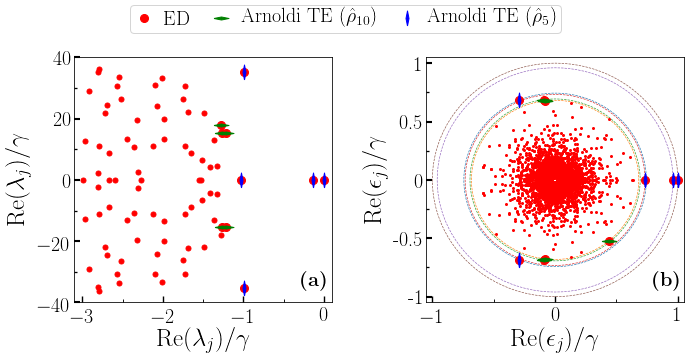

In [17]:
gg=LLval[np.real(LLval>-3)]
gg=gg[np.abs(np.imag(gg))<38]
      
    
to_plot_5=vals_liouv_good_5
to_plot_10=[]
for vv in vals_liouv_good_10:
    if min([abs(ww - vv) for ww in to_plot_5])>0.01:
        to_plot_10.append(vv)

to_plot_big=[]
to_plot_small=[]

for ww in gg:
    if min([abs(ww - vv) for vv in vals_liouv_good_10])>0.01:
        to_plot_small.append(ww)
    else:
        to_plot_big.append(ww)

fig, axs = plt.subplots(1,2, figsize=(10,5.2))
axs[0].plot(np.real(to_plot_big), np.imag(to_plot_big), 'ro', markersize=8, label='ED')
axs[0].plot(np.real(to_plot_small), np.imag(to_plot_small), 'ro', markersize=5)
axs[0].plot(np.real(to_plot_10), np.imag(to_plot_10), 'g', linestyle='None',  marker=mine_2, markersize=15)
axs[0].plot(np.real(to_plot_5), np.imag(to_plot_5), 'b', linestyle='None',  marker=mine, markersize=15)
axs[0].set_xlim([-3.1, 0.1])
axs[0].set_ylim([-40, 40])

axs[0].set_xlabel(r'Re$(\lambda_j)/\gamma$')
axs[0].set_ylabel(r'Re$(\lambda_j)/\gamma$')



power=6

theta=np.linspace(0, 2*np.pi, 101)
radius_list=[1099]
for vv in np.sort(vals_good_10):
    vv=vv**power
    radius=abs(vv)
    if not(min([abs(rr-radius) for rr in radius_list])<0.01):
        radius_list.append(radius)
        axs[1].plot(np.real(vv*np.exp(1.j*theta)), np.imag(vv*np.exp(1.j*theta)), linestyle='--', lw=0.65)



to_plot_5=vals_good_5
to_plot_10=[]
for vv in vals_good_10:
    if min([abs(ww - vv) for ww in vals_good_5])>0.01:
        to_plot_10.append(vv)        

to_plot_big=[]
to_plot_small=[]

expval=np.array([np.exp(ll*T) for ll in LLval])


for ww in expval:
    if min([abs(ww - vv) for vv in vals_good_10])>0.01:
        to_plot_small.append(ww**power)
    else:
        to_plot_big.append(ww**power)        



axs[1].plot(np.real(to_plot_small), np.imag(to_plot_small), 'ro', markersize=2)


axs[1].plot(np.real(to_plot_big), np.imag(to_plot_big), 'ro', markersize=8)
axs[1].plot(np.real([vv**power for vv in to_plot_10]), np.imag([vv**power for vv in to_plot_10]),'g', linestyle='None',  marker=mine_2, markersize=15, label=r'Arnoldi TE ($\hat{\rho}_{10}$)')
axs[1].plot(np.real([vv**power for vv in to_plot_5]), np.imag([vv**power for vv in to_plot_5]),'b', linestyle='None',  marker=mine, markersize=15, label=r'Arnoldi TE ($\hat{\rho}_{5}$)')



axs[1].set_xlim([-1.05, 1.05])
axs[1].set_ylim([-1.05, 1.05])

axs[1].set_xlabel(r'Re$(\epsilon_j)/\gamma$')
axs[1].set_ylabel(r'Re$(\epsilon_j)/\gamma$')

plt.tight_layout(rect=[0,0,1,0.93])

leg = fig.legend(loc='upper center',ncol=8, borderpad=0.2, labelspacing=1, handlelength=1, handletextpad=0.5, borderaxespad=0.25, columnspacing=1, fontsize=20)


axs[0].annotate(r'\bf{(a)}', xy=get_axis_limits(axs[0],0.88, 0.07))
axs[1].annotate(r'\bf{(b)}', xy=get_axis_limits(axs[1],0.88, 0.07))

axs[1].set_yticks([-1, -0.5, 0, 0.5, 1])
axs[1].set_yticklabels(['-1', '-0.5', '0', '0.5', '1'])
plt.show()

## Calculating the expectation value of e.g. the steady state

In [18]:
rhoss_eff = Qobj(vecs_eff_ss[0])

In [19]:
rhoss_eff = rhoss_eff/rhoss_eff.tr()

In [20]:
rhoss_eff = Qobj(rhoss_eff.full(), dims=[[8,8],[8,8]], shape = (64,64))

In [21]:
expect(a.dag()*a, rhoss_eff)

0.5406308044912576

## and with the exact solution

In [22]:
#steady state
rhoss = steadystate(LL)
print(expect(a.dag()*a, rhoss))

0.5413273372204629


## quick check of the difference between both

In [23]:
print(np.abs(expect(a.dag()*a, rhoss) - expect(a.dag()*a, rhoss_eff)))

0.0006965327292053347


This difference can be either improved by decreasing the value of tau (i.e. the measure of convergence) or calculating more eigenvalues (in other words, a few more iterations are usually needed to find the next eigenvalues, also improving the estimation of the steady state)